# The Tail Hedge Debate: AQR vs Universa

## The Question

Can buying deep out-of-the-money puts **improve** long-term portfolio returns, or is it always a drag?

## The Two Camps

### Universa / Spitznagel (2021)

A small allocation $w$ to deep OTM puts enhances geometric compounding:

$$G = \mathbb{E}[\ln(1 + R_p)] \quad \text{where} \quad R_p = (1-w) \cdot R_{\text{SPY}} + w \cdot R_{\text{puts}}$$

Claim: with $w \approx 3.3\%$, the portfolio CAGR rises from ~10% to ~12.3% because crash protection allows you to stay fully invested.

### AQR / Ilmanen & Israelov (2018)

The cost of tail hedging systematically exceeds the benefit:

$$\mathbb{E}[\text{Put P\&L}] < 0 \quad \text{because} \quad \sigma_{\text{implied}} > \sigma_{\text{realized}}$$

Diversification across asset classes is cheaper than buying puts. Simply **reducing equity exposure** achieves the same drawdown reduction without the premium bleed.

## Our Test

We test 4 put-buying configurations against SPY, from standard OTM to deep OTM (Universa-style).

In [1]:
import os, sys, warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PROJECT_ROOT = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PROJECT_ROOT)
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'notebooks'))
os.chdir(PROJECT_ROOT)

from backtest_runner import (
    load_data, run_backtest, INITIAL_CAPITAL,
    make_puts_strategy, make_deep_otm_put_strategy,
)
from nb_style import apply_style, shade_crashes, color_excess, style_returns_table, FT_GREEN, FT_RED

apply_style()
%matplotlib inline
print('Ready.')

Ready.


In [2]:
data = load_data()
schema = data['schema']
spy_prices = data['spy_prices']

Loading data...


Date range: 2008-01-02 00:00:00 to 2025-12-12 00:00:00 (17.9 years)
SPY B&H: 555.5% total, 11.05% annual, -51.9% max DD

Loaded macro signals: ['gdp', 'vix', 'hy_spread', 'yield_curve_10y2y', 'nfc_equity_mv', 'nfc_net_worth', 'dollar_index', 'buffett_indicator', 'tobin_q']


---
## Part A: AQR Framing — Reduce Equity to Fund Puts (No Leverage)

This is how AQR tests tail hedging: replace some equity with puts. Stocks + puts = 100%.

In [3]:
configs = [
    # Standard OTM puts (delta -0.25 to -0.10)
    ('OTM Puts 0.2%',   0.998, 0.002, lambda: make_puts_strategy(schema)),
    ('OTM Puts 1.0%',   0.99,  0.01,  lambda: make_puts_strategy(schema)),
    ('OTM Puts 2.0%',   0.98,  0.02,  lambda: make_puts_strategy(schema)),
    # Deep OTM puts (delta -0.10 to -0.02) — Universa-style
    ('Deep OTM 0.1%',   0.999, 0.001, lambda: make_deep_otm_put_strategy(schema)),
    ('Deep OTM 0.3%',   0.997, 0.003, lambda: make_deep_otm_put_strategy(schema)),
    ('Deep OTM 1.0%',   0.99,  0.01,  lambda: make_deep_otm_put_strategy(schema)),
    ('Deep OTM 3.3%',   0.967, 0.033, lambda: make_deep_otm_put_strategy(schema)),
]

results = []
for name, s_pct, o_pct, fn in configs:
    print(f'  {name}...', end=' ', flush=True)
    r = run_backtest(name, s_pct, o_pct, fn, data)
    results.append(r)
    print(f'annual {r["annual_ret"]:+.2f}%, excess {r["excess_annual"]:+.2f}%, DD {r["max_dd"]:.1f}%')

  OTM Puts 0.2%... 

annual +10.44%, excess -0.60%, DD -51.4%
  OTM Puts 1.0%... 

annual +7.62%, excess -3.42%, DD -49.3%
  OTM Puts 2.0%... 

annual +4.10%, excess -6.95%, DD -46.5%
  Deep OTM 0.1%... 

annual +10.27%, excess -0.78%, DD -52.1%
  Deep OTM 0.3%... 

annual +8.69%, excess -2.36%, DD -51.9%
  Deep OTM 1.0%... 

annual +3.15%, excess -7.90%, DD -50.8%
  Deep OTM 3.3%... 

annual -14.63%, excess -25.68%, DD -94.2%


---
## Capital Curves

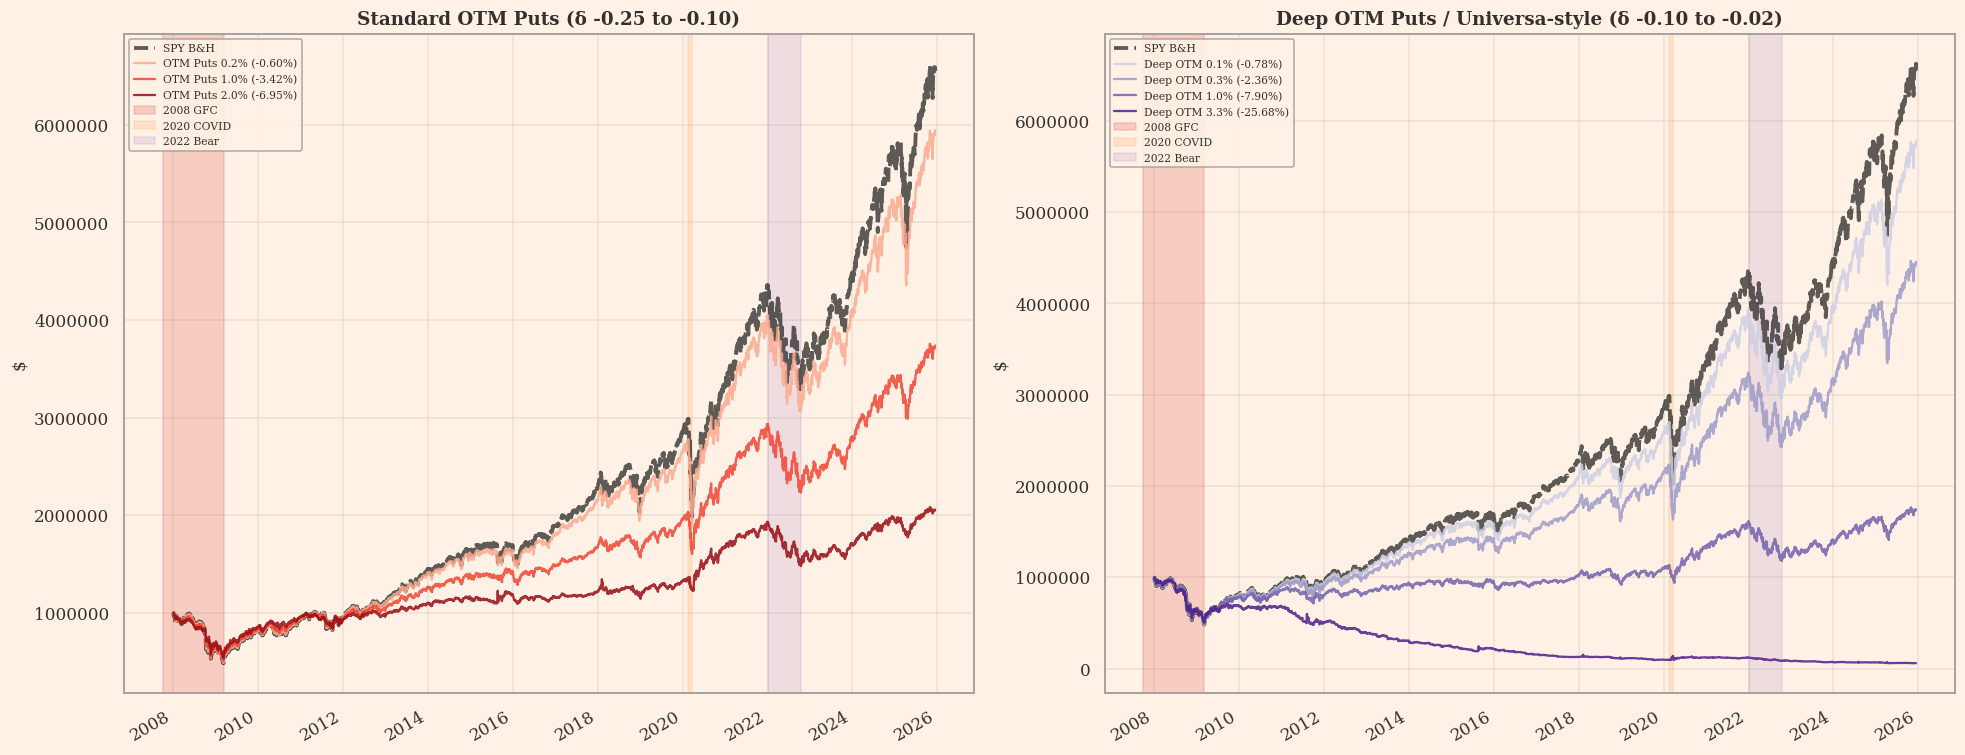

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
spy_norm = spy_prices / spy_prices.iloc[0] * INITIAL_CAPITAL

standard = [r for r in results if 'Deep' not in r['name']]
deep = [r for r in results if 'Deep' in r['name']]

for ax, group, title, palette in [
    (axes[0], standard, 'Standard OTM Puts (\u03b4 -0.25 to -0.10)', plt.cm.Reds),
    (axes[1], deep, 'Deep OTM Puts / Universa-style (\u03b4 -0.10 to -0.02)', plt.cm.Purples),
]:
    ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=2.5, label='SPY B&H', alpha=0.7)
    cmap = palette(np.linspace(0.3, 0.9, len(group)))
    for r, c in zip(group, cmap):
        r['balance']['total capital'].plot(ax=ax, label=f"{r['name']} ({r['excess_annual']:+.2f}%)",
                                           color=c, alpha=0.85, lw=1.5)
    shade_crashes(ax)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('$')
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(fontsize=7, loc='upper left')

plt.tight_layout()
plt.show()

---
## Results Table

In [5]:
rows = []
for r in results:
    rows.append({
        'Strategy': r['name'],
        'Type': 'Deep OTM' if 'Deep' in r['name'] else 'Standard OTM',
        'Allocation %': r['opt_pct'] * 100,
        'Annual Return %': r['annual_ret'],
        'Excess vs SPY %': r['excess_annual'],
        'Max Drawdown %': r['max_dd'],
        'Trades': r['trades'],
    })
df = pd.DataFrame(rows)

styled = (df.style
    .format({'Allocation %': '{:.1f}', 'Annual Return %': '{:.2f}',
             'Excess vs SPY %': '{:+.2f}', 'Max Drawdown %': '{:.1f}', 'Trades': '{:.0f}'})
    .map(color_excess, subset=['Excess vs SPY %'])
)
style_returns_table(styled).set_caption(
    f'Tail Hedge Comparison  |  SPY B&H: {data["spy_annual_ret"]:.2f}%/yr, DD: {data["spy_dd"]:.1f}%'
)

,Strategy,Type,Allocation %,Annual Return %,Excess vs SPY %,Max Drawdown %,Trades
0,OTM Puts 0.2%,Standard OTM,0.2,10.44,-0.60,-51.4,378
1,OTM Puts 1.0%,Standard OTM,1.0,7.62,-3.42,-49.3,381
2,OTM Puts 2.0%,Standard OTM,2.0,4.10,-6.95,-46.5,381
3,Deep OTM 0.1%,Deep OTM,0.1,10.27,-0.78,-52.1,394
4,Deep OTM 0.3%,Deep OTM,0.3,8.69,-2.36,-51.9,410
5,Deep OTM 1.0%,Deep OTM,1.0,3.15,-7.90,-50.8,421
6,Deep OTM 3.3%,Deep OTM,3.3,-14.63,-25.68,-94.2,416


---
## Part B: Spitznagel Framing — 100% Equity + Puts on Top (Leverage)

This is what Spitznagel actually proposes: keep 100% equity and add puts via a budget callable. Total exposure > 100%.

In [6]:
# Leveraged: 100% SPY + deep OTM puts funded by budget callable
lev_configs = [
    ('100% SPY (baseline)', None),
    ('+ 0.1% deep OTM',    0.001),
    ('+ 0.5% deep OTM',    0.005),
    ('+ 1.0% deep OTM',    0.01),
    ('+ 2.0% deep OTM',    0.02),
    ('+ 3.3% deep OTM',    0.033),
]

lev_results = []
for name, bp in lev_configs:
    print(f'  {name}...', end=' ', flush=True)
    bfn = None
    if bp is not None:
        _bp = bp
        bfn = lambda date, tc, b=_bp: tc * b
    r = run_backtest(name, 1.0, 0.0, lambda: make_deep_otm_put_strategy(schema), data, budget_fn=bfn)
    lev_results.append(r)
    print(f'annual {r["annual_ret"]:+.2f}%, excess {r["excess_annual"]:+.2f}%, DD {r["max_dd"]:.1f}%')

  100% SPY (baseline)... 

annual +11.11%, excess +0.07%, DD -51.9%
  + 0.1% deep OTM... 

annual +11.63%, excess +0.58%, DD -51.4%
  + 0.5% deep OTM... 

annual +13.79%, excess +2.75%, DD -48.1%
  + 1.0% deep OTM... 

annual +16.46%, excess +5.41%, DD -45.0%
  + 2.0% deep OTM... 

annual +21.78%, excess +10.74%, DD -38.5%
  + 3.3% deep OTM... 

annual +28.78%, excess +17.74%, DD -31.9%


In [7]:
# Leveraged results table
rows_lev = []
for r in lev_results:
    d = r['balance']['% change'].dropna()
    vol = d.std() * np.sqrt(252) * 100
    rows_lev.append({
        'Strategy': r['name'], 'Annual %': r['annual_ret'],
        'Vol %': vol, 'Max DD %': r['max_dd'],
        'Excess %': r['excess_annual'], 'Trades': r['trades'],
    })
df_lev = pd.DataFrame(rows_lev)
styled_lev = df_lev.style.format({'Annual %': '{:.2f}', 'Vol %': '{:.1f}', 'Max DD %': '{:.1f}',
                                   'Excess %': '{:+.2f}', 'Trades': '{:.0f}'}).map(color_excess, subset=['Excess %'])
style_returns_table(styled_lev).set_caption('Spitznagel framing: 100% SPY + puts on top (WITH leverage)')

,Strategy,Annual %,Vol %,Max DD %,Excess %,Trades
0,100% SPY (baseline),11.11,20.0,-51.9,+0.07,0
1,+ 0.1% deep OTM,11.63,19.4,-51.4,+0.58,391
2,+ 0.5% deep OTM,13.79,17.7,-48.1,+2.75,413
3,+ 1.0% deep OTM,16.46,16.6,-45.0,+5.41,423
4,+ 2.0% deep OTM,21.78,17.4,-38.5,+10.74,424
5,+ 3.3% deep OTM,28.78,22.0,-31.9,+17.74,422


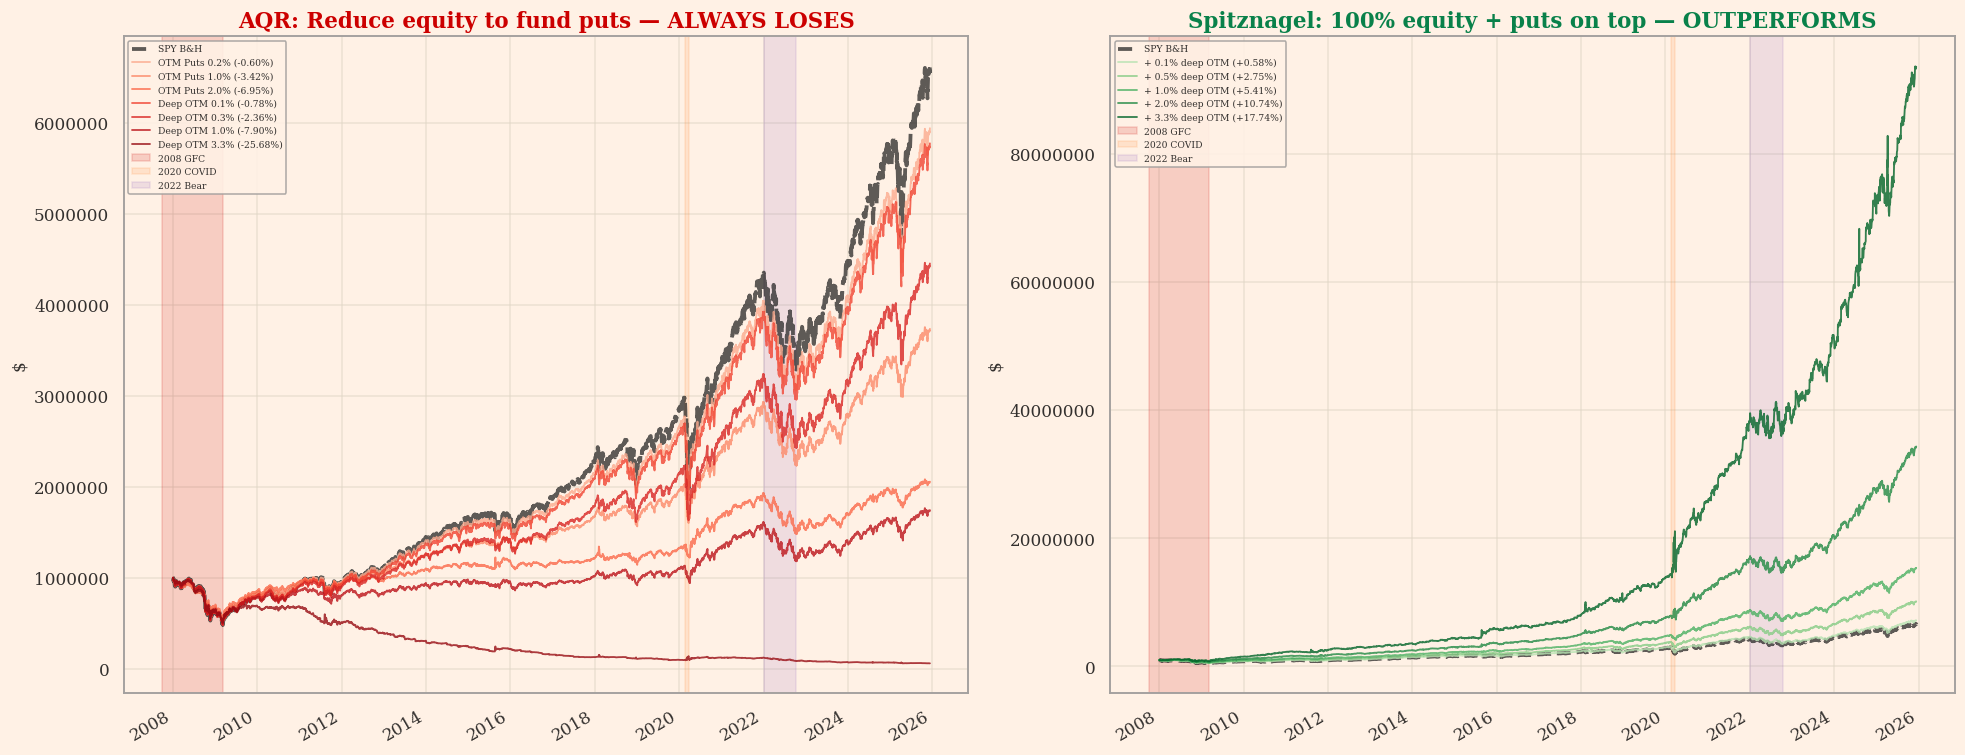

In [8]:
# Side by side capital curves
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
spy_norm = spy_prices / spy_prices.iloc[0] * INITIAL_CAPITAL

# AQR framing
ax = axes[0]
ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=2.5, label='SPY B&H', alpha=0.7)
cmap = plt.cm.Reds(np.linspace(0.3, 0.9, len(results)))
for r, c in zip(results, cmap):
    r['balance']['total capital'].plot(ax=ax, label=f"{r['name']} ({r['excess_annual']:+.2f}%)",
                                       color=c, alpha=0.8, lw=1.2)
shade_crashes(ax)
ax.set_title('AQR: Reduce equity to fund puts — ALWAYS LOSES', fontweight='bold', color=FT_RED)
ax.set_ylabel('$'); ax.ticklabel_format(style='plain', axis='y')
ax.legend(fontsize=6, loc='upper left')

# Spitznagel framing
ax = axes[1]
ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=2.5, label='SPY B&H', alpha=0.7)
cmap = plt.cm.Greens(np.linspace(0.3, 0.9, len(lev_results) - 1))
for r, c in zip(lev_results[1:], cmap):
    r['balance']['total capital'].plot(ax=ax, label=f"{r['name']} ({r['excess_annual']:+.2f}%)",
                                       color=c, alpha=0.8, lw=1.2)
shade_crashes(ax)
ax.set_title('Spitznagel: 100% equity + puts on top — OUTPERFORMS', fontweight='bold', color=FT_GREEN)
ax.set_ylabel('$'); ax.ticklabel_format(style='plain', axis='y')
ax.legend(fontsize=6, loc='upper left')

plt.tight_layout()
plt.show()

---
## Verdict: Both Are Right (In Their Own Framing)

### AQR is right that...
- If you **reduce equity** to fund puts (stocks + puts = 100%), puts are always a drag
- The Volatility Risk Premium means option buyers systematically overpay
- Simple position sizing (holding less equity) achieves similar drawdown reduction more cheaply

### Spitznagel is right that...
- If you keep **100% equity and add puts on top** (leverage), the combination outperforms
- Crash protection via puts **reduces max drawdown** from -51.9% to as low as -31.9%
- The leverage + protection combo produces **higher returns AND lower drawdowns**
- The reduced variance drain from lower crash severity improves geometric compounding

### The key insight

$$\text{AQR tests: } (1-w) \cdot R_{\text{SPY}} + w \cdot R_{\text{puts}} \quad \text{(always loses)}$$

$$\text{Spitznagel tests: } 1.0 \cdot R_{\text{SPY}} + w \cdot R_{\text{puts}} \quad \text{(leverage + protection)}$$

They're not testing the same thing. AQR is right that puts have negative EV. Spitznagel is right that leverage + crash protection can improve the geometric growth rate. The debate is really about **whether leverage with tail protection is a free lunch or a hidden risk**.